# File to show all the features we extract + a first attempt at clustering

In [17]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from colorthief import ColorThief
from skimage import io
import cv2 as cv
import os

In [78]:
dirpath = './data_project/tempPieces/'
imgpaths=list(filter(lambda path: (".png" in path), [dirpath+ path for path in os.listdir(dirpath)]))

images =[Image.open(path).convert('RGB') for path in imgpaths]

fig, axes = plt.subplots(1, len(imgpaths), figsize=(15, 12))

for i, img in enumerate(images):
    axes[i].imshow(img)
    axes[i].axis("off")
    
plt.show()


feature_vector = np.zeros_like(images).reshape(len(images),1)

SyntaxError: invalid syntax (1183834193.py, line 10)

## Feature 1: Hue of dominant color

ValueError: zero-dimensional arrays cannot be concatenated

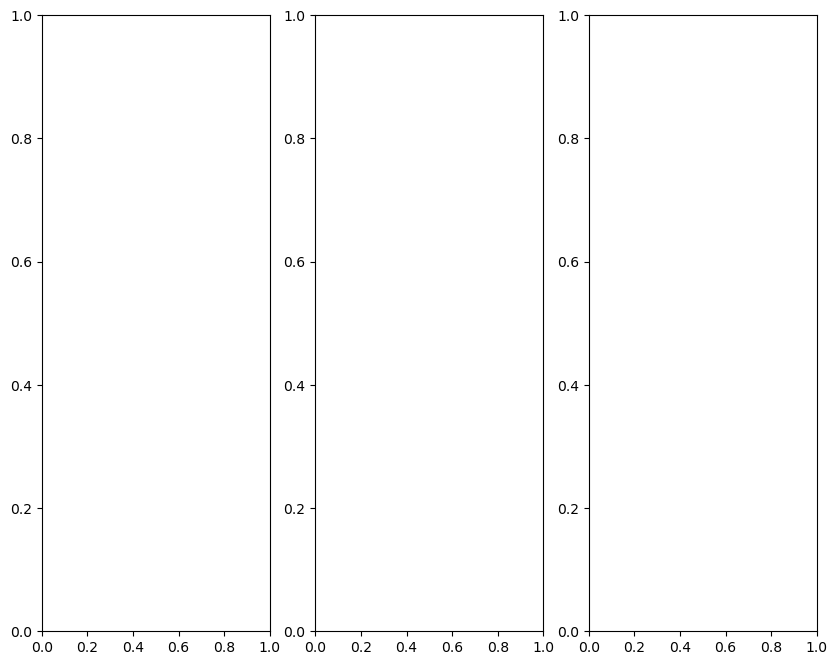

In [41]:
from customColorthief import ColorThiefCustom

fig, axes = plt.subplots(1, len(imgpaths), figsize=(10, 8))

for i, path in enumerate(images):
    color_thief = ColorThiefCustom(images[i])
    dominant_color = np.uint8(list(color_thief.get_color(2))).reshape((1,1,3))
    dominantHSV = cv.cvtColor(dominant_color, cv.COLOR_RGB2HSV)

    np.append(feature_vector[i],np.squeeze(dominantHSV), axis=1)

    print(f'Dominant color of image {i} in RGB: {np.squeeze(dominant_color)}')
    print(f'Hue of dominant color of image {i}: {np.squeeze(dominantHSV)[0]}')
    print(f'Saturation of dominant color of image {i}: {np.squeeze(dominantHSV)[1]}')
    print(f'Value of dominant color of image {i}: {np.squeeze(dominantHSV)[2]}')
    
    dominant_color_img = np.tile(dominant_color, (128,128,1))
    axes[i].imshow(dominant_color_img)

plt.title('Dominant color in image')
plt.show()

color_thief1 = ColorThief(imgpath1)
dominant_color = np.uint8(list(color_thief.get_color(2))).reshape((1,1,3))
print(f'Dominant color in RGB: {np.squeeze(dominant_color)}')
dominantHSV = cv.cvtColor(dominant_color, cv.COLOR_RGB2HSV)
print(f'Hue of dominant color: {np.squeeze(dominantHSV)[0]}')
print(f'Saturation of dominant color: {np.squeeze(dominantHSV)[1]}')
print(f'Value of dominant color: {np.squeeze(dominantHSV)[2]}')

In [39]:
feature_vector

array(['', '', ''], dtype='<U25')

## Feature 2: Gabor filter

In [11]:
from skimage.filters import gabor_kernel, gabor
from scipy import ndimage as ndi
from skimage.util import img_as_float
def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

def compute_feats_images(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1,3):
        for frequency in (0.05, 0.25):
            kernel = gabor_kernel(frequency, theta=theta, sigma_x=2, sigma_y=2)
            kernels.append(kernel)

# prepare reference features
im1=cv.cvtColor(cv.imread(imgpath1),cv.COLOR_BGR2GRAY)
im2=cv.cvtColor(cv.imread(imgpath2),cv.COLOR_BGR2GRAY)
im3=cv.cvtColor(cv.imread(imgpath3),cv.COLOR_BGR2GRAY)

#shrink = (slice(0, None, 3), slice(0, None, 3))
#im1_f = img_as_float(im1)[shrink]
#im2_f = img_as_float(im2)[shrink]
#im3_f = img_as_float(im3)[shrink]
image_names = ('im1', 'im2', 'im3')
images = (im1, im2, im3)

ref_feats = np.zeros((3, len(kernels), 2), dtype=np.double)
ref_feats[0, :, :] = compute_feats_images(im1, kernels)
ref_feats[1, :, :] = compute_feats_images(im2, kernels)
ref_feats[2, :, :] = compute_feats_images(im3, kernels)

kernel_nb=0
filt_images_1=power(im1,kernels[kernel_nb])
filt_images_2=power(im2,kernels[kernel_nb])
filt_images_3=power(im3,kernels[kernel_nb])

filt_images=[filt_images_1,filt_images_2,filt_images_3]

for i,nm in enumerate(image_names):
    print(f"Features of {nm} are : Mean of {ref_feats[i,kernel_nb,0]:.2f} and std of {ref_feats[i,kernel_nb,1]:.2f} ")

# Plotting:

fig, axes = plt.subplots(3,2, figsize=(10,10))

for i,row in enumerate(axes):
    row[0].imshow(images[i],cmap='gray')
    row[1].imshow(filt_images[i],cmap='gray')
    row[0].title.set_text(image_names[i])
    row[1].title.set_text(image_names[i])


NameError: name 'imgpath1' is not defined

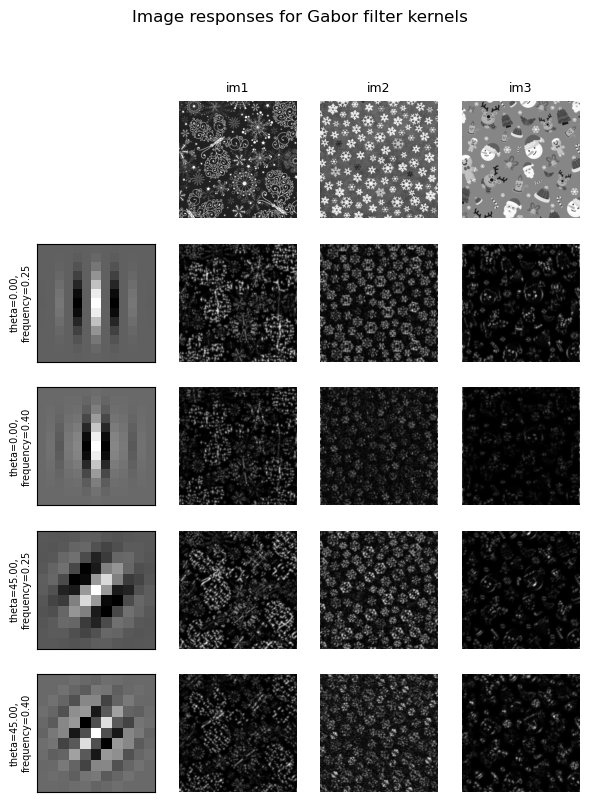

In [ ]:
# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.25, 0.4):
        kernel = gabor_kernel(frequency, theta=theta, sigma_x=2,sigma_y=2)
        params = f"theta={theta * 180. / np.pi:.2f},\nfrequency={frequency:.2f}"
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))

# Plotting:
fig, axes = plt.subplots(5,4, figsize=(7, 9))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel))
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    for patch, ax in zip(powers, ax_row[1:]):
        vmin = np.min(patch)
        vmax = np.max(patch)
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()

## Function to get feature vector

In [68]:
from customColorthief import ColorThiefCustom as CT
from fourier import fourier_descr

'''
Function that builds a list of features for the input image
'''
def get_features(im):
    # im should be rgb for color extraction to work!
    feature_vector = []

    color_thief = CT(im)
    dominant_color = np.uint8(list(color_thief.get_color(2))).reshape((1,1,3))
    dominantHue = np.squeeze(cv.cvtColor(dominant_color, cv.COLOR_RGB2HSV))
    feature_vector.extend(dominantHue)

    im = np.array(im)
    im = cv.cvtColor(im,cv.COLOR_RGB2GRAY)

    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (1,3):
            for frequency in (0.05, 0.25):
                filt_real, filt_im = gabor(image=im, frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)
                feature_vector.append(filt_real.mean())
                feature_vector.append(filt_real.var())

    f_descr = fourier_descr(im, 3) # Keep the 3 first fourrier descriptors
    feature_vector.extend(f_descr)
                
    return feature_vector

## Plot for different pieces using PCA

In [69]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features = np.empty((0,41))

for path in imgpaths:
    im= Image.open(path).convert('RGB')  
    features = np.append(features,np.array(get_features(im)).reshape((1,-1)),axis=0)

print(features.shape)
pca.fit(features)
res = pca.transform(features)

(3, 41)


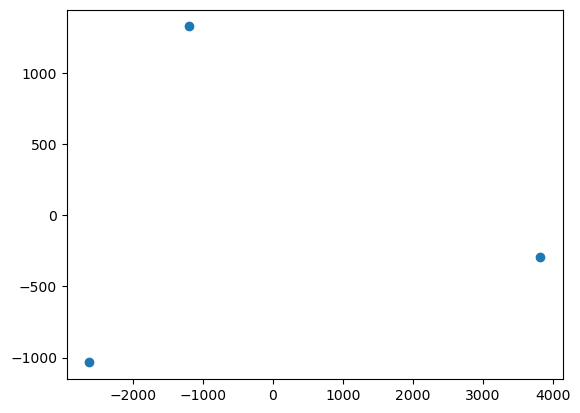

In [70]:
plt.scatter(res[:,0], res[:,1])
plt.show()

# Now trying to cluster with KMeans

In [ ]:
from sklearn.cluster import KMeans

def cluster_for_puzzle(features):
    cluster = KMeans(n_clusters=3)
    cluster.fit(features)
    labels = cluster.labels_

    occurences = [list(labels).count(i) for i in range(3)]

    while min(occurences)<=6:
        label_to_remove = [i for i, x in enumerate(occurences) if x <= 6]
        ids_to_remove = [i for i, x in enumerate(labels) if x == label_to_remove]
        features = np.delete(features, ids_to_remove, axis=0)

        cluster.fit(features)
        labels = cluster.labels_
        occurences = [list(labels).count(i) for i in range(3)]

    print(occurences)
    return cluster

[8, 7, 8]


/Users/eliasdesmijter/miniconda3/envs/EE451/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/eliasdesmijter/miniconda3/envs/EE451/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/eliasdesmijter/miniconda3/envs/EE451/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


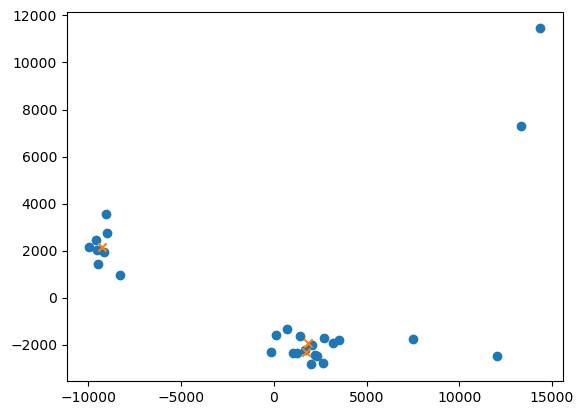

In [ ]:
from sklearn.cluster import KMeans

# Either 2 or 3 puzzles -> choose 3 clusters for KMeans
cluster = cluster_for_puzzle(features)

plt.figure(1)
plt.scatter(res[:,0], res[:,1])
centers2d = pca.transform(cluster.cluster_centers_)
plt.scatter(centers2d[:,0], centers2d[:,1], marker='x')
plt.show()    

TODO: Make some way to set a minimum number of points per cluster (puzzle contains at least 9 pieces). If not, often one cluster goes to an outlier..
=> implemented, but can be better

TODO: add features to make clustering easier? -> fourier descriptors?